Run through some calculations to determine the best way to set up the global, iterative, greedy activation calculation test.

**NOTE** - assumes that ``extract_aerosol_files`` has already been run.

In [11]:
from collections import namedtuple
from functools import reduce

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import numpy as np
import xray

MARC_modes = ['AIT', 'ACC', 'MOS', 'MBS']

Load a dataset into memory, and setup some extra fields which might be useful. 

In [2]:
d = xray.open_dataset("aerosol_dists.subset.nc")

/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/xray/conventions.py:382: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)


---

## N and $\mu$ distributions

Since our goal is to study the situation where all 4 main CCN-supplying modes are present, we need to identify reasonable threshholds on $N$ and $\mu$ for each of those modes. We don't want to exclude *too* many parameter combinations, but we need parameter sets that will have interesting activation characteristics.

First, we can plot the distributions of $N$ and $\mu$ for each mode, and visually inspect them.

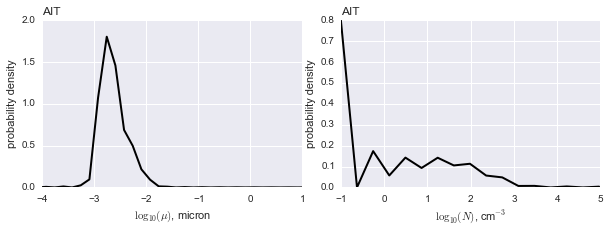

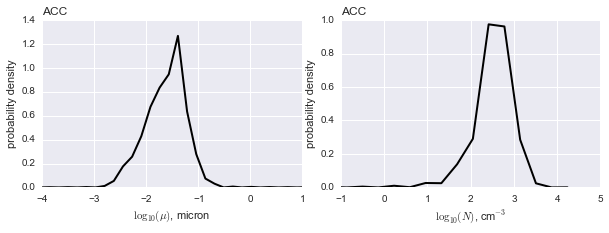

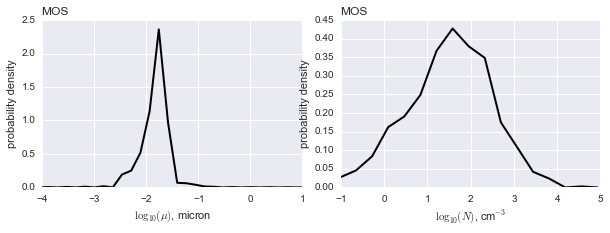

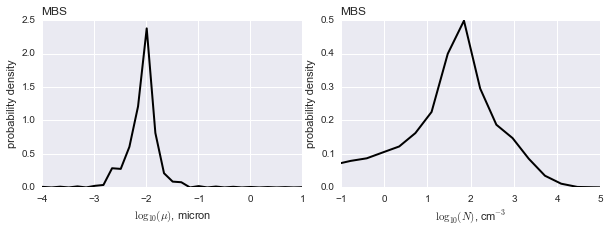

In [7]:
plt_type = 'kde'

for mode in MARC_modes:
        
    mus = np.log10(d['mu%s' % mode].data.ravel())
    Ns = np.log10(d['n%s' % mode].data.ravel())
    
    fig, (ax_mu, ax_N) = plt.subplots(1, 2, figsize=(10,3))
    
    if plt_type == 'hist':
        ax_mu.hist(mus, normed=True)
        ax_N.hist(Ns, normed=True)
    elif plt_type == 'kde':
        kde_args = dict(lw=2, color='k')
        sns.kdeplot(mus, ax=ax_mu, **kde_args)
        sns.kdeplot(Ns, ax=ax_N, **kde_args)
    
    for ax in [ax_mu, ax_N]:
        ax.set_title(mode, loc='left')
        ax.set_ylabel("probability density")
        
    ax_mu.set_xlabel("$\log_{10}(\mu)$, micron")
    ax_N.set_xlabel("$\log_{10}(N)$, cm$^{-3}$")
    
    ax_N.set_xlim(-1, 5)
    ax_mu.set_xlim(-4, 1)
    
    plt.draw()

There are very obvious places to cut the tails of the $\mu$ distributions, and any reasonable restriction on $N$ should suffice given the broadness of their distributions. So let's ask the question - how does the choice of a generic threshold affect how many parameter sets will be available?

In [45]:
lt = lambda a, b: a & b

def parameter_sets(nthresh, muthresh, 
                   muAITthresh=None):
    if muAITthresh is None:
        muAITthresh = muthresh
    
    mapping =  [ ]
    mapping += [ ( d['n%s' % mode].data, nthresh ) for mode
                                                   in MARC_modes ]
    mapping += [ ( d['mu%s' % mode].data, muthresh ) for mode 
                                                    in MARC_modes ]

    fields, thresholds = zip(*mapping)
    mask = reduce(lt, [(field > thresh) for field, thresh 
                                        in zip(fields, thresholds)])
    return np.count_nonzero(mask)

bins = 25
mus = np.logspace(-5, np.log10(5e-3), bins)
Ns = np.logspace(0, 1, bins)

n_sets = np.empty((bins, bins))
for i in range(bins):
    mu = mus[i]
    for j in range(bins):
        N = Ns[j]
        
        n_sets[i, j] = parameter_sets(N, mu)

/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


59560
59560
1278720


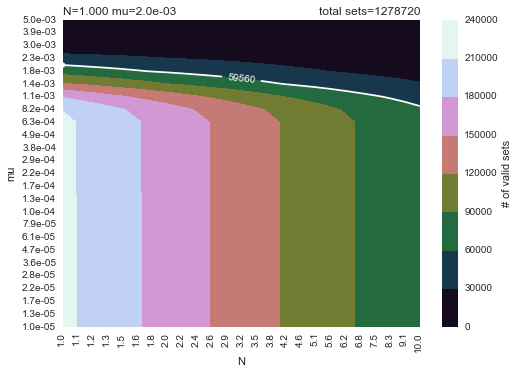

In [51]:
plt.contourf(Ns, mus, n_sets, cmap="cubehelix")
plt.loglog()
plt.xlabel("N")
plt.ylabel("mu")

plt.xticks(Ns, ["%3.1f" % N for N in Ns], rotation=90)
plt.yticks(mus, ["%3.1e" % mu for mu in mus])

plt.xlim(Ns[0], Ns[-1])
plt.ylim(mus[0], mus[-1])

cb = plt.colorbar()
cb.set_label("# of valid sets")

N, mu = 1., 2e-3
plt.scatter([N, ], [mu, ], s=20, color='w', zorder=999)
n_set_all = parameter_sets(N, mu)
c = plt.contour(Ns, mus, n_sets, levels=[n_set_all, ], 
                color=('w', 'k'), linestyles=('-', '--'))
plt.clabel(c, fmt="%d")
plt.title("N={:1.3f} mu={:1.1e}".format(N,mu), loc='left')

n_set_tot = len(d.lat)*len(d.lev)*len(d.lon)*len(d.time)
plt.title("total sets={}".format(n_set_tot), loc='right')

print(n_set_all)
print(n_set_ait)
print(n_set_tot)
plt.savefig("figs/greedy_sets_threshold.png")

Based on this analysis, it looks like a simple, straightforward approach would be to simply use $N \geq 1 \text{cm}^{-3}$ and $\mu \geq 2 \text{nm}$

In [31]:
plt.clabel?

In [5]:
# Cleanup
d.close()